In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import zipfile
import matplotlib.pyplot as plt
import shutil
import opendatasets as od
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

In [4]:
od.download( 
    "https://www.kaggle.com/datasets/shubhamgoel27/dermnet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  claracarissa


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/shubhamgoel27/dermnet


100%|██████████████████████████████████████████████████████████████████████████████| 1.72G/1.72G [31:44<00:00, 970kB/s]

In [46]:
traindir_path = ['dermnet/train/Acne and Rosacea Photos', 'dermnet/train/Bullous Disease Photos', 'dermnet/train/Exanthems and Drug Eruptions',
            'dermnet/train/Hair Loss Photos Alopecia and other Hair Diseases', 'dermnet/train/Herpes HPV and other STDs Photos',
            'dermnet/train/Melanoma Skin Cancer Nevi and Moles', 'dermnet/train/Psoriasis pictures Lichen Planus and related diseases',
            'dermnet/train/Systemic Disease', 'dermnet/train/Vascular Tumors']

testdir_path = ['dermnet/test/Acne and Rosacea Photos', 'dermnet/test/Bullous Disease Photos', 'dermnet/test/Exanthems and Drug Eruptions',
            'dermnet/test/Hair Loss Photos Alopecia and other Hair Diseases', 'dermnet/test/Herpes HPV and other STDs Photos',
            'dermnet/test/Melanoma Skin Cancer Nevi and Moles', 'dermnet/test/Psoriasis pictures Lichen Planus and related diseases',
            'dermnet/test/Systemic Disease', 'dermnet/test/Vascular Tumors']

In [47]:
# Check if the file exists before attempting to delete it
for path in traindir_path+testdir_path:
  if os.path.exists(path):
      shutil.rmtree(path)
      print(f"The file {path} has been deleted.")
  else:
      print(f"The file {path} does not exist.")

The file dermnet/train/Acne and Rosacea Photos has been deleted.
The file dermnet/train/Bullous Disease Photos has been deleted.
The file dermnet/train/Exanthems and Drug Eruptions has been deleted.
The file dermnet/train/Hair Loss Photos Alopecia and other Hair Diseases has been deleted.
The file dermnet/train/Herpes HPV and other STDs Photos has been deleted.
The file dermnet/train/Melanoma Skin Cancer Nevi and Moles has been deleted.
The file dermnet/train/Psoriasis pictures Lichen Planus and related diseases has been deleted.
The file dermnet/train/Systemic Disease has been deleted.
The file dermnet/train/Vascular Tumors has been deleted.
The file dermnet/test/Acne and Rosacea Photos has been deleted.
The file dermnet/test/Bullous Disease Photos has been deleted.
The file dermnet/test/Exanthems and Drug Eruptions has been deleted.
The file dermnet/test/Hair Loss Photos Alopecia and other Hair Diseases has been deleted.
The file dermnet/test/Herpes HPV and other STDs Photos has been

In [48]:
BATCH_SIZE = 32 # 32
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)

In [49]:
# Define the training and validation base directories
DATASET_DIR = 'dermnet'
TRAINING_DIR='dermnet/train'
VALIDATION_DIR='dermnet/test'

In [50]:
print(f'DATASET_DIR: {DATASET_DIR}')
print(f'IMG_SIZE: {IMG_SIZE}')
print(f'IMG_SHAPE: {IMG_SHAPE}')
print(f'TRAINING_DIR: {TRAINING_DIR}')
print(f'VALIDATION_DIR: {VALIDATION_DIR}')

DATASET_DIR: dermnet
IMG_SIZE: (256, 256)
IMG_SHAPE: (256, 256, 3)
TRAINING_DIR: dermnet/train
VALIDATION_DIR: dermnet/test


In [51]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator()

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=IMG_SIZE,
                                                      shuffle=True)

  validation_datagen = ImageDataGenerator()

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=IMG_SIZE)
  return train_generator, validation_generator

In [52]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 10265 images belonging to 14 classes.
Found 2573 images belonging to 14 classes.


In [53]:
train_generator.class_indices

{'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 0,
 'Atopic Dermatitis Photos': 1,
 'Cellulitis Impetigo and other Bacterial Infections': 2,
 'Eczema Photos': 3,
 'Light Diseases and Disorders of Pigmentation': 4,
 'Lupus and other Connective Tissue diseases': 5,
 'Nail Fungus and other Nail Disease': 6,
 'Poison Ivy Photos and other Contact Dermatitis': 7,
 'Scabies Lyme Disease and other Infestations and Bites': 8,
 'Seborrheic Keratoses and other Benign Tumors': 9,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 10,
 'Urticaria Hives': 11,
 'Vasculitis Photos': 12,
 'Warts Molluscum and other Viral Infections': 13}

### **CALLBACK**

In [54]:
# Define a Callback class that stops training once accuracy reaches 95.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks=myCallback()

### **InceptionV3**

In [55]:
import urllib.request
import zipfile
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [67]:
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
pre_trained_model = InceptionV3(input_shape = IMG_SHAPE,
                                include_top = False,
                                weights = 'imagenet')

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

87910968/87910968 [==============================] - 173s 2us/step


In [63]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 127, 127, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 127, 127, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 127, 127, 32)         0         ['batch_normalizati

In [68]:
# Build Model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Build Model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = inputs # data_augmentation(inputs)
x = preprocess_input(x)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

In [69]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [70]:
loss0, accuracy0 = model.evaluate(validation_generator)
print((loss0, accuracy0))

81/81 [==============================] - 82s 973ms/step - loss: 2.7251 - accuracy: 0.0692
(2.725097894668579, 0.0691799446940422)


In [ ]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 100,
            callbacks = [callbacks])

Epoch 1/100
321/321 [==============================] - 382s 1s/step - loss: 1.7480 - accuracy: 0.4312 - val_loss: 1.8031 - val_accuracy: 0.4116
Epoch 2/100
321/321 [==============================] - 406s 1s/step - loss: 1.6221 - accuracy: 0.4661 - val_loss: 1.9057 - val_accuracy: 0.3735
Epoch 3/100
321/321 [==============================] - 406s 1s/step - loss: 1.5104 - accuracy: 0.5056 - val_loss: 1.8068 - val_accuracy: 0.4260
Epoch 4/100
321/321 [==============================] - 390s 1s/step - loss: 1.3862 - accuracy: 0.5448 - val_loss: 1.7856 - val_accuracy: 0.4298
Epoch 5/100
321/321 [==============================] - 401s 1s/step - loss: 1.2830 - accuracy: 0.5837 - val_loss: 1.7323 - val_accuracy: 0.4567
Epoch 6/100
321/321 [==============================] - 383s 1s/step - loss: 1.1637 - accuracy: 0.6202 - val_loss: 1.9184 - val_accuracy: 0.4427
Epoch 7/100
321/321 [==============================] - 377s 1s/step - loss: 1.0569 - accuracy: 0.6514 - val_loss: 1.9278 - val_accuracy:

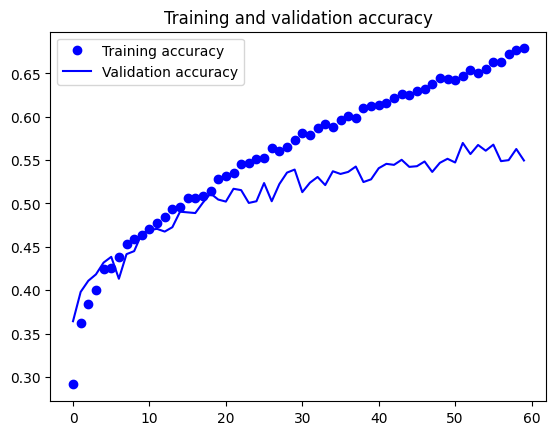

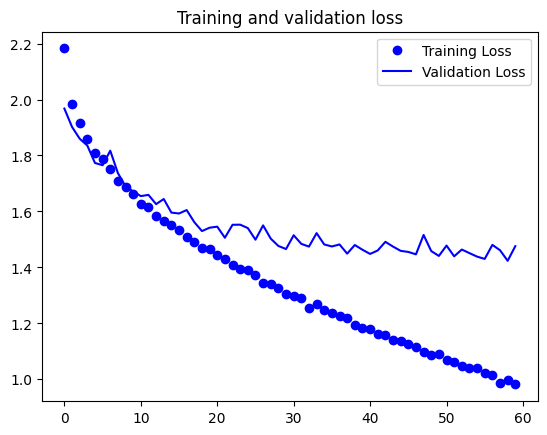

In [35]:
def plot_hist(hist):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_hist(history)

In [36]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_3
1 conv2d_188
2 batch_normalization_188
3 activation_188
4 conv2d_189
5 batch_normalization_189
6 activation_189
7 conv2d_190
8 batch_normalization_190
9 activation_190
10 max_pooling2d_8
11 conv2d_191
12 batch_normalization_191
13 activation_191
14 conv2d_192
15 batch_normalization_192
16 activation_192
17 max_pooling2d_9
18 conv2d_196
19 batch_normalization_196
20 activation_196
21 conv2d_194
22 conv2d_197
23 batch_normalization_194
24 batch_normalization_197
25 activation_194
26 activation_197
27 average_pooling2d_18
28 conv2d_193
29 conv2d_195
30 conv2d_198
31 conv2d_199
32 batch_normalization_193
33 batch_normalization_195
34 batch_normalization_198
35 batch_normalization_199
36 activation_193
37 activation_195
38 activation_198
39 activation_199
40 mixed0
41 conv2d_203
42 batch_normalization_203
43 activation_203
44 conv2d_201
45 conv2d_204
46 batch_normalization_201
47 batch_normalization_204
48 activation_201
49 activation_204
50 average_pooling2d_19
51 conv2d_200
52 c

Epoch 1/7
321/321 [==============================] - 856s 3s/step - loss: 1.1824 - accuracy: 0.6110 - val_loss: 1.4705 - val_accuracy: 0.5523
Epoch 2/7
321/321 [==============================] - 759s 2s/step - loss: 1.0539 - accuracy: 0.6555 - val_loss: 1.4494 - val_accuracy: 0.5554
Epoch 3/7
321/321 [==============================] - 739s 2s/step - loss: 1.0028 - accuracy: 0.6715 - val_loss: 1.4462 - val_accuracy: 0.5624
Epoch 4/7
321/321 [==============================] - 754s 2s/step - loss: 0.9832 - accuracy: 0.6773 - val_loss: 1.4433 - val_accuracy: 0.5600
Epoch 5/7
321/321 [==============================] - 776s 2s/step - loss: 0.9768 - accuracy: 0.6801 - val_loss: 1.4509 - val_accuracy: 0.5608
Epoch 6/7
321/321 [==============================] - 799s 2s/step - loss: 0.9660 - accuracy: 0.6797 - val_loss: 1.4399 - val_accuracy: 0.5659
Epoch 7/7
321/321 [==============================] - 830s 3s/step - loss: 0.9475 - accuracy: 0.6851 - val_loss: 1.4278 - val_accuracy: 0.5651


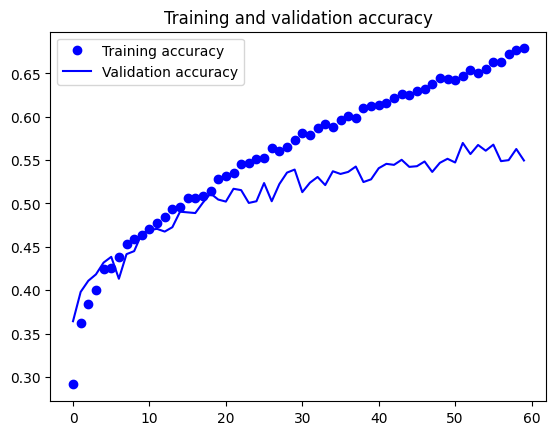

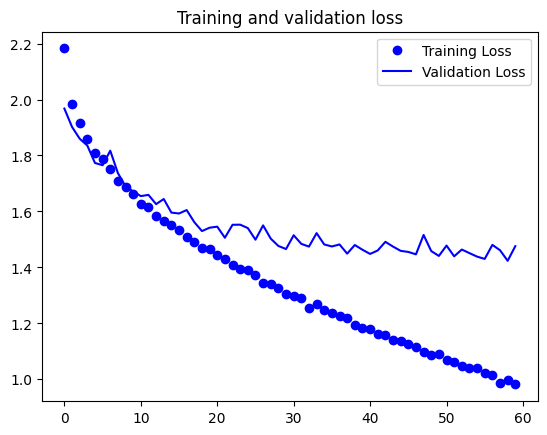

In [37]:
def unfreeze_model(model):
    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:197]:
       layer.trainable = False
    for layer in model.layers[197:]:
       layer.trainable = True

    optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(
        optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 7  # @param {type: "slider", min:4, max:10}
hist = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
plot_hist(hist)

### **SAVE MODEL**

In [19]:
# Save the model as .bin and .json
model.save("model.bin") 
model.save("model.json")

INFO:tensorflow:Assets written to: model.bin\assets


INFO:tensorflow:Assets written to: model.bin\assets


INFO:tensorflow:Assets written to: model.json\assets


INFO:tensorflow:Assets written to: model.json\assets


NameError: name 'files' is not defined

In [20]:
# Save the model as .bin and .json
model.save("model2.bin") 
model.save("model2.json")  

# Download the files
from IPython.display import FileLink
FileLink(r'model2.bin')
FileLink(r'model2.json')

INFO:tensorflow:Assets written to: model2.bin\assets


INFO:tensorflow:Assets written to: model2.bin\assets


INFO:tensorflow:Assets written to: model2.json\assets


INFO:tensorflow:Assets written to: model2.json\assets


ValueError: Cannot display a directory using FileLink. Use FileLinks to display 'model2.bin'.

In [22]:
!pip install h5_to_json

In [23]:
from h5_to_json import convert_h5_to_json

convert_h5_to_json("model3.h5", "model3.json", data_dir="weights")

# data_dir (optional): Directory to save extracted binary data (weights).

ImportError: cannot import name 'convert_h5_to_json' from 'h5_to_json' (c:\users\clara carissa\appdata\local\programs\python\python39\lib\site-packages\h5_to_json\__init__.py)

In [30]:
import torch

In [31]:
torch.save(model.state_dict(), "weights2.bin")

AttributeError: 'Functional' object has no attribute 'state_dict'

In [32]:
torch.save(model, 'saved_weights2.bin')

INFO:tensorflow:Assets written to: ram://c5d7727c-92b6-41a7-8133-f7eba370853a/assets


INFO:tensorflow:Assets written to: ram://c5d7727c-92b6-41a7-8133-f7eba370853a/assets


In [41]:
model_json = model.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("model3.bin")
print("Saved model .......")

Saved model .......


In [38]:
model.save("model4.h5")

In [40]:
!tensorflowjs_converter --input_format=keras model4.h5 model4.json


Traceback (most recent call last):
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <modu

In [ ]:
model_save_path = "./tmp/dummymodel.h5"
modelin.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
files.download('/content/tmp/dummymodel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install tensorflowjs

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import time
!tensorflowjs_converter \
    --input_format=keras dummymodel.h5 ./
# !tensorflowjs_converter --input_format=keras dummymodel.h5 dummymodel.json

2024-05-22 08:00:39.657255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 08:00:41.916920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 949, in convert
    _dispatch_converter(input_format, o

In [ ]:
!zip dummypol.zip *.bin modelin.json

	zip warning: name not matched: *.bin
	zip warning: name not matched: modelin.json

zip error: Nothing to do! (dummypol.zip)
